In [1]:
%%capture
!pip install timm segmentation_models_pytorch albumentations

In [2]:
import os
import cv2
import tarfile
import numpy as np
import pandas as pd
from math import ceil
from time import time
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from torchvision.models import segmentation as seg

%matplotlib inline

In [3]:
np.random.seed(42)
torch.manual_seed(42)

# Setting up GPU

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Extracting images to local storage

!rm -r /content/Dataset

my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/Dataset.tar.xz')
my_tar.extractall()
my_tar.close()

my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/data_bordered.tar.xz')
my_tar.extractall()
my_tar.close()

my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/pseudo_labels_par_means.tar.xz')
my_tar.extractall()
my_tar.close()

# Image path list

In [8]:
original_image_path = '/content/Dataset/1.training/1.training'
#cutmix_image_path = '/content/Dataset/cutmix_augmentation'
constant_image_path = '/content/data_border_constant'
reflect_image_path = '/content/data_border_reflect'

original_mask_path = '/content/1.training_pseudo_labels'
cutmix_mask_path = '/content/cutmix_augmentation_pseudo_labels'
constant_mask_path = '/content/data_border_constant_pseudo_labels'
reflect_mask_path = '/content/data_border_reflect_pseudo_labels'

In [9]:
original_mask_path = '/content/training_pseudo_labels'
#cutmix_mask_path = '/content/cutmix_augmentation_pseudo_labels'
constant_mask_path = '/content/border_constant_pseudo_labels'
reflect_mask_path = '/content/border_reflect_pseudo_labels'

In [10]:
image_path_list = []

In [11]:
def img_list(data_path, label_path):
  
  path_list = []
  # getting list of all the images
  images = os.listdir(data_path)
  #exc_list = ['[1, 1, 0]', '[1, 0, 1]', '[0, 1, 1]', '[1, 1, 1]']
  # setting the flag based on the image path
  '''
  if path == orig_image_path:
    flag = 0
  else:
    flag = 1
  '''
  # don't need the flag, just resize all the images while loading to (224, 224)

  # adding to the image_path_list
  for i in images:
    # adding the image path, flag and the label
    #image_path_list[0].append([path + '/' + str(i), flag, list(map(int, i[-13:-4].strip('][').split(', ')))])
    #print(list(map(int, i[-13:-4].strip('][').split(', '))))
    if 'DS_S' in str(i):
      continue
    path_list.append([data_path + '/' + str(i), label_path + '/' + str(i)])
  
  return path_list

In [12]:
# loading image paths
original_list = img_list(original_image_path, original_mask_path)
const_list = img_list(constant_image_path, constant_mask_path)
refl_list = img_list(reflect_image_path, reflect_mask_path)

In [13]:
print(len(original_list), len(const_list), len(refl_list))

10091 10091 10091


In [14]:
original_list = [x for x in original_list if ('[1, 0, 0]' in x[0]) or\
                                             ('[0, 1, 0]' in x[0]) or\
                                             ('[0, 0, 1]' in x[0])]# or\
                                             #('[1, 1, 0]' in x[0])]

const_list = [x for x in const_list if ('[1, 0, 0]' in x[0]) or\
                                       ('[0, 1, 0]' in x[0]) or\
                                       ('[0, 0, 1]' in x[0])]

refl_list = [x for x in refl_list if ('[1, 0, 0]' in x[0]) or\
                                     ('[0, 1, 0]' in x[0]) or\
                                     ('[0, 0, 1]' in x[0])]

In [15]:
print(len(original_list), len(const_list), len(refl_list))

4693 4693 4693


In [16]:
image_path_list.extend(original_list)
image_path_list.extend(const_list)
image_path_list.extend(refl_list)

In [17]:
len(image_path_list)

14079

In [18]:
np.random.shuffle(image_path_list)

In [19]:
image_path_list[np.random.randint(0, 12000)]

['/content/data_border_constant/1222870-19356-4464-[0, 0, 1].png',
 '/content/border_constant_pseudo_labels/1222870-19356-4464-[0, 0, 1].png']

image_path_list = [x for x in image_path_list if ('[1, 0, 0]' in x[0]) or\
                                                 ('[0, 1, 0]' in x[0]) or\
                                                 ('[0, 0, 1]' in x[0])]

len(test_list)

## Creating the dataset class

In [50]:
# Creating the dataset class for the data

class LUAD(Dataset):
  """Lung Adenocarcinoma Histopathological images."""
  
  def __init__(self, image_list, transform = None):
    
    """
      Args:
        image_list: csv/list/numpy array containing image paths, flag and labels.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
    #Loading the csv file containing the image paths and one-hot encoded labels
    #self.image_paths_labels = pd.read_csv(csv_file)
    self.image_list = image_list
    self.transform = transform
    self.mask_transform = transforms.Compose([transforms.ToTensor(),
                                              transforms.Resize((224, 224)),
                                              ])

  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    # code when input is a csv file
    '''
    image = cv2.imread(image_paths_labels.iloc[idx, 0])
    image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W) do this in transforms
    labels = self.image_paths_labels.iloc[idx, 1]
    labels = np.array([labels])
    labels = labels.astype('int').reshape(-1, 3)        # check what exactly to do with this
    sample = {'image': image, 'labels': labels}
    '''
    #print(idx) keeps printing 
    # code when the input is a list of image paths and labels
    image = cv2.imread(self.image_list[idx][0])
    #image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W)
    mask = cv2.imread(self.image_list[idx][1], cv2.IMREAD_UNCHANGED)/255
    mask = mask.astype('int').astype('float32')
    #sample = {'image': image, 'mask': mask}
    
    if self.transform is not None:
      #sample = self.transform(sample)
      image = self.transform(image)
      mask = self.mask_transform(mask)
      #transformed = self.transform(image = image, mask = mask)
      #image = transformed['image']
      #mask = transformed['mask']
    
    return image, mask
    #return sample #['image'], sample['mask']

14079
0 (224, 224, 3) (224, 224, 4)
1 (224, 224, 3) (224, 224, 4)
2 (224, 224, 3) (224, 224, 4)
3 (276, 154, 3) (276, 154, 4)


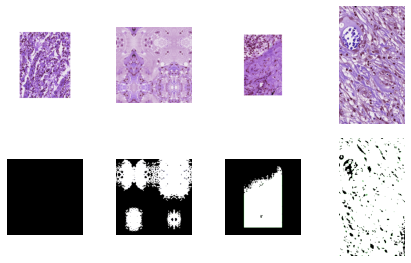

In [51]:
# check if the dataloader works
check_loader = LUAD(image_list=image_path_list)

print(len(check_loader))
fig = plt.figure()

for i in range(len(check_loader)):
    #sample = check_loader[i]
    image, mask = check_loader[i]

    print(i, image.shape, mask.shape)

    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    #ax.set_title(sample['labels'])
    ax.axis('off')
    plt.imshow(image)

    ax = plt.subplot(2, 4, i + 1 + 4)
    plt.tight_layout()
    #ax.set_title(sample['labels'])
    ax.axis('off')
    plt.imshow(mask)

    if i == 3:
        plt.show()
        break

In [52]:
'''
random_augs = ([#transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
               #transforms.RandomGrayscale(p=0.1),            #Grayscale(num_output_channels=3),
               #transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
               #transforms.RandomHorizontalFlip(p=0.5),
               #transforms.RandomVerticalFlip(p=0.5),
               #transforms.RandomRotation(30),
               transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
               #transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
               #transforms.RandomAdjustSharpness(sharpness_factor=2),
               ])

'''
# creatin the train dataset
train_dataset = LUAD(image_path_list,
                     transform = transforms.Compose([transforms.ToTensor(),
                                                     transforms.Resize((224, 224)),
                                                     #transforms.RandomApply(random_augs, p=0.4),
                                                     transforms.Normalize([0.698, 0.535, 0.768], [0.134, 0.192, 0.149]),]
                                                     )
                     )
'''
train_dataset = LUAD(image_path_list,
                     transform = A.Compose([A.Resize(224, 224),
                                            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                                            A.HorizontalFlip(0.5),
                                            A.VerticalFlip(0.5),
                                            #A.Normalize([0.698, 0.535, 0.768], [0.134, 0.192, 0.149]),
                                            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                            ToTensorV2(),]
                                           )
                     )
'''

'\ntrain_dataset = LUAD(image_path_list,\n                     transform = A.Compose([A.Resize(224, 224),\n                                            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),\n                                            A.HorizontalFlip(0.5),\n                                            A.VerticalFlip(0.5),\n                                            #A.Normalize([0.698, 0.535, 0.768], [0.134, 0.192, 0.149]),\n                                            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),\n                                            ToTensorV2(),]\n                                           )\n                     )\n'

In [53]:
batch_size = 32

In [54]:
# train dataloader
train_dataloader = DataLoader(train_dataset,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 1,
                              )

# test dataloader
#test_dataloader = DataLoader(test_dataset,
#                             batch_size = batch_size,
#                             shuffle = True,
#                             num_workers = 1,
#                             )

In [55]:
len(train_dataloader)

440

# Testing if transforms applies uniformly

iterator = iter(train_dataloader)

images, masks = next(iterator)

print(type(np.asarray(images)), type(np.asarray(masks)))
print(np.asarray(images).shape, np.asarray(masks).shape)
#print(len(images), len(masks))

print(images.shape, masks.shape, type(images), type(mask))

masks.permute(0, 3, 1, 2).shape

fig = plt.figure(figsize=(20, 20))

for i in range(batch_size):
    #sample = check_loader[i]
    image, mask = check_loader[i]

    print(i, image.shape, mask.shape)

    ax = fig.add_subplot(2, 4, i + 1)
    plt.tight_layout()
    #ax.set_title(sample['labels'])
    ax.axis('off')
    plt.imshow(images[i].permute(1, 2, 0).numpy())

    ax = fig.add_subplot(2, 4, i + 1 + 4)
    plt.tight_layout()
    #ax.set_title(sample['labels'])
    ax.axis('off')
    plt.imshow(masks[i].numpy())

# Creating the model

model = seg.deeplabv3_resnet50(weights='DeepLabV3_ResNet50_Weights.DEFAULT',
                               progress = True,
                               #num_classes = 3,
                               #weights_backbone = 'ResNet50_Weights.IMAGENET1K_V1',
                               )
model.classifier = seg.deeplabv3.DeepLabHead(2048, 3)
model.aux_classifier = seg.deeplabv3.FCNHead(1024, 3)

In [56]:
model = smp.DeepLabV3Plus(encoder_name='resnet50', classes=4, activation=None, ).to(device)

In [57]:
model.load_state_dict(torch.load(f='/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/deeplabv3plus_means_dJ_par_resnet50_03.pth', map_location=device))

<All keys matched successfully>

In [58]:
#model

In [59]:
#model.eval()
#torchsummary.summary(model, (3, 224, 224))

### Checking model properties

model(torch.randn(1, 3, 224, 224).to(device))

out = model(torch.randn(1, 3, 224, 224).to(device))
out

y_p = nn.functional.softmax(out, dim = -1)
y_p

#y_p = y_p.round().detach().cpu().numpy()
y_p = y_p.round()
#y_p = nn.Threshold(0.25, 1.0)(y_p)
y_p

y_p.shape

'''
l = np.array([[0, 0, 1],
              [1, 0, 0],
              [0, 0, 1],
              [0, 0, 1],
              [0, 0, 1],
              [0, 0, 1],
              [0, 1, 0],
              [1, 0, 0],
              [0, 0, 1],
              [0, 0, 1],]).astype('float32')
'''

l = np.array([[1., 0., 0.],
              [0., 0., 1.],
              [0., 1., 0.],
              [0., 0., 1.],
              [1., 0., 0.],
              [0., 1., 0.],
              [0., 0., 1.],
              [0., 1., 0.],
              [0., 1., 0.],
              [0., 1., 0.]]).astype('float32')

l = torch.tensor(l).to(device)

y_p.dtype

accuracy_score(l.cpu().detach().numpy().argmax(axis=1),
               y_p.cpu().detach().numpy().argmax(axis=1))

loss = nn.CrossEntropyLoss()

loss(out, l)

## Training and validation

In [60]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               opt: torch.optim.Optimizer,
               #eval_fn = accuracy_score,
               device: torch.device = device
               ):
  
  train_loss, train_acc = 0, 0
  model.train()
  loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=False,)
  for batch, (x, y) in loop:
    
    #if (batch % 20 == 0) or (batch == len(data_loader)-1): print(f'batch: {batch}')
    #print(f'batch: {batch}')
    #x = data['image']
    #y = data['labels']
    
    # permute mask from NHWC to NCHW
    y = y.permute(0, 3, 1, 2)
    
    # send data to GPU
    x, y = x.to(device), y.to(device)
    
    #clear gradients
    opt.zero_grad()

    # forward pass
    model_out = model(x)
    
    y_pred = nn.functional.softmax(model_out, dim = -1)
    #print(y_pred.shape, y_pred.dtype)
    #print(y.shape, y.dtype)
    # calculate loss
    #loss = loss_fn(model_out, y)
    loss = loss_fn[0](model_out, y) + loss_fn[1](model_out, y)
    
    train_loss += loss
    #train_acc += eval_fn(y.cpu().detach().numpy().argmax(axis=1),
    #                     y_pred.cpu().detach().numpy().argmax(axis=1))

    # back-prop
    loss.backward()

    # optimize
    opt.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  #train_acc /= len(data_loader)
  #print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}")
  print(f"Train loss: {train_loss:.5f}")

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=smp.utils.losses.DiceLoss() + smp.utils.losses.BCELoss(), 
    metrics=[smp.utils.metrics.Accuracy(threshold=0.5, activation=None, ignore_channels=None)], 
    optimizer=torch.optim.SGD(model.parameters(), lr=0.0001,
                              nesterov=True, momentum=0.01),
    device=device,
    verbose=False,
)

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              eval_fn = accuracy_score,
              device: torch.device = device
              ):
  test_loss, test_acc = 0, 0
  model.eval() # put model in eval mode
  
  # Turn on inference context manager
  with torch.inference_mode(): 
    for (X, y) in data_loader:

      #x = data['image']
      #y = data['labels']
      
      # Send data to GPU
      X, y = X.to(device), y.to(device)
      
      # 1. Forward pass
      model_out = model(X)
      test_pred = torch.sigmoid(model_out).round()
      
      # 2. Calculate loss and accuracy
      test_loss += loss_fn(model_out, y)
      test_acc += eval_fn(y.cpu().detach().numpy().astype('float32'),
                          test_pred.cpu().detach().numpy().astype('float32'))
      
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}\n")
    return test_loss, test_acc

In [61]:
model_save_path = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/deeplabv3plus_means_dJ_par_resnet50_03.pth'

In [62]:
epochs = 50

In [63]:
valid_acc = -np.inf

In [64]:
for epoch in tqdm(range(epochs)):

  print(f"Epoch: {epoch + 1} / {epochs}\n---------")
  
  train_step(data_loader=train_dataloader,
             model=model,
             #loss_fn=nn.CrossEntropyLoss(),
             #loss_fn=torch.nn.MSELoss(reduction='mean'),
             #loss_fn=[smp.losses.DiceLoss(mode = 'multiclass'), smp.losses.JaccardLoss(mode = 'multiclass')],
             loss_fn=[smp.losses.DiceLoss(mode = 'multilabel'), smp.losses.JaccardLoss(mode = 'multilabel')],
             #opt=torch.optim.SGD(model.parameters(), lr=0.000001, nesterov=True, momentum=0.09),
             opt=torch.optim.AdamW(params=model.parameters(), lr=0.00001, ) #weight_decay=0.1
             #eval_fn=accuracy_score,
             )
  
  #train_logs = train_epoch.run(train_dataloader)
  '''
  # validation named as test step
  ep_v_loss, ep_v_acc = test_step(data_loader=test_dataloader,
                                  model=model_vit_base_patch16_224,
                                  loss_fn=nn.MultiLabelSoftMarginLoss(),
                                  eval_fn=accuracy_score
                                  )
  
  if ep_v_acc > valid_acc:
    print(f"accuracy increased from {valid_acc} to {ep_v_acc} saving model to: {model_save_path}")
    torch.save(obj = model_vit_base_patch16_224.state_dict(),
               f = model_save_path)
    valid_acc = ep_v_acc
  
  else:
    print(f"accuracy did not increased from {valid_acc}")
'''
#torch.save(obj = model.state_dict(), f = model_save_path)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 / 50
---------


  0%|          | 0/440 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
torch.save(obj = model.state_dict(), f = model_save_path)